In [22]:
## comment

In [23]:
## install

# !pip install kagglehub
# !pip install opencv-python
# !pip install transformers torch scikit-learn matplotlib pillow

In [24]:
## import

import kagglehub
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from transformers import ViTFeatureExtractor, ViTModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
from torchvision import models, transforms
from sklearn.decomposition import PCA

In [25]:
## model, class, variables

def load_images_from_folder(folder, image_size=(224, 224)):
    images = []
    image_files = []
    i=-1
    for filename in os.listdir(folder)[:1000]:
        i+=1
        if i%100==0: 
            print(i)
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                img = Image.open(os.path.join(folder, filename)).convert('RGB')
                img = img.resize(image_size)  # Resize for ViT input size
                images.append(img)
                image_files.append(filename)
            except Exception as e:
                print(f"Could not load image {filename}: {e}")
    return images, image_files

def get_image_embeddings(images):
    embeddings = []
    for img in images:
        inputs = feature_extractor(images=img, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract the [CLS] token as the image embedding
        embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(embedding)
    # Convert the list of arrays into a single numpy array
    embeddings = np.vstack(embeddings)
    return embeddings

def find_optimal_clusters(embeddings, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg}")
    # Select the number of clusters with the highest silhouette score
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f"Optimal number of clusters: {optimal_clusters}")
    return optimal_clusters

def visualize_clusters(images, image_files, cluster_labels, n_samples=3):
    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        if len(clusters[label]) < n_samples:
            clusters[label].append(image_files[i])
    
    # Plot images from each cluster
    plt.figure(figsize=(10, 10))
    for cluster_id, img_files in clusters.items():
        for i, img_file in enumerate(img_files):
            img_path = os.path.join(image_folder, img_file)
            img = Image.open(img_path)
            plt.subplot(len(clusters), n_samples, cluster_id * n_samples + i + 1)
            plt.imshow(img)
            plt.title(f"Cluster {cluster_id}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def get_image_embeddings_resnet(images):
    embeddings = []
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    for img in images:
        img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            outputs = resnet_model(img_tensor)
        embedding = outputs.flatten().cpu().numpy()  # Flatten to a 1D array
        embeddings.append(embedding)
    
    embeddings = np.vstack(embeddings)
    return embeddings

In [7]:
## ViT

image_folder = 'inputs/mnist_test/'
images, image_files = load_images_from_folder(image_folder)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')
print("Generating embeddings for images...")
embeddings = get_image_embeddings(images)
print("Embeddings shape:", embeddings.shape)
# optimal_clusters = find_optimal_clusters(embeddings)
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
visualize_clusters(images, image_files, cluster_labels)

In [7]:
## ResNet

image_folder = 'inputs/mnist_test/'
images, image_files = load_images_from_folder(image_folder)
resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])
print("Generating embeddings using ResNet for images...")
embeddings = get_image_embeddings_resnet(images)
print("Embeddings shape:", embeddings.shape)
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
visualize_clusters(images, image_files, cluster_labels)

In [13]:
## combined(ViT, ResNet)

image_folder = 'inputs/mnist_test/'
images, image_files = load_images_from_folder(image_folder)
print("Generating embeddings using ViT for images...")
vit_embeddings = get_image_embeddings(images)  # Shape: (num_images, 768)
print("ViT Embeddings shape:", vit_embeddings.shape)
print("Generating embeddings using ResNet for images...")
resnet_embeddings = get_image_embeddings_resnet(images)  # Shape: (num_images, 2048)
print("ResNet Embeddings shape:", resnet_embeddings.shape)
combined_embeddings = np.hstack((vit_embeddings, resnet_embeddings))  # Shape: (num_images, 768 + 2048)
print("Combined Embeddings shape:", combined_embeddings.shape)
print("Finding optimal clusters for combined embeddings...")
optimal_clusters = 10  # You can use find_optimal_clusters(combined_embeddings) if needed
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(combined_embeddings)
print("Visualizing clusters for combined embeddings...")
visualize_clusters(images, image_files, cluster_labels)

0
100
200
300
400
500
600
700
800
900
Generating embeddings using ViT for images...
ViT Embeddings shape: (1000, 768)
Generating embeddings using ResNet for images...
ResNet Embeddings shape: (1000, 2048)
Combined Embeddings shape: (1000, 2816)
Applying PCA to reduce to 10 principal components...
Reduced Embeddings shape: (1000, 10)
Finding optimal clusters for PCA-reduced embeddings...
Visualizing clusters for PCA-reduced embeddings...


/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


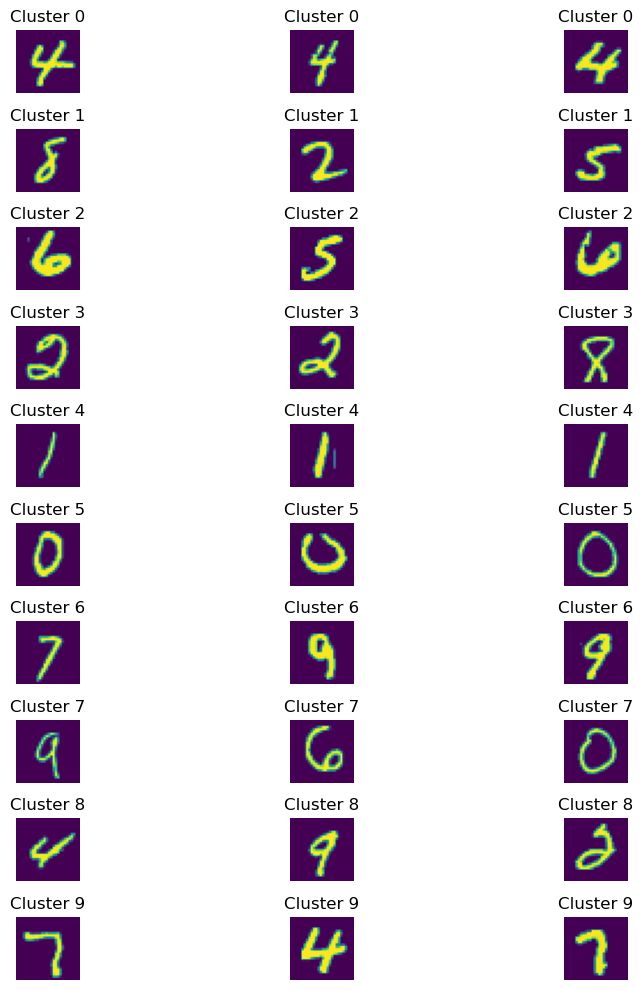

In [26]:
## PCA(combined(ViT, ResNet))

image_folder = 'inputs/mnist_test/'
images, image_files = load_images_from_folder(image_folder)
print("Generating embeddings using ViT for images...")
vit_embeddings = get_image_embeddings(images)  # Shape: (num_images, 768)
print("ViT Embeddings shape:", vit_embeddings.shape)
print("Generating embeddings using ResNet for images...")
resnet_embeddings = get_image_embeddings_resnet(images)  # Shape: (num_images, 2048)
print("ResNet Embeddings shape:", resnet_embeddings.shape)
combined_embeddings = np.hstack((vit_embeddings, resnet_embeddings))  # Shape: (num_images, 768 + 2048)
print("Combined Embeddings shape:", combined_embeddings.shape)
print("Applying PCA to reduce to 10 principal components...")
pca = PCA(n_components=10)
reduced_embeddings = pca.fit_transform(combined_embeddings)  # Shape: (num_images, 10)
print("Reduced Embeddings shape:", reduced_embeddings.shape)
print("Finding optimal clusters for PCA-reduced embeddings...")
optimal_clusters = 10  # You can use find_optimal_clusters(reduced_embeddings) if needed
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)
print("Visualizing clusters for PCA-reduced embeddings...")
visualize_clusters(images, image_files, cluster_labels)